In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70
plt.rcParams['figure.figsize'] = [10, 5]
from pathlib import Path

from parsing.zero_coupon import ZeroCoupon
import statsmodels.api as sm

##### Риск-факторы:

* IMOEX
* RTSI с поправкой на индикативный курс USDRUB ЦБ
* Валюта
* Кривая бескупонной доходности


In [552]:
_imoex_path = Path('..', 'data', 'index', 'history', 'IMOEX.csv')
_rtsi_path = Path('..', 'data', 'index', 'history', 'RTSI.csv')
_CB_rate_path = Path('..', 'data', 'credit_rate.csv')
_indicative_rate_path = Path('..', 'data', 'RUB_ind.csv')
_deposits_path = Path('..', 'data', 'deposits', 'RUB.pickle')
_CNY_Path = Path('..', 'data', 'currencies', 'history', 'CNYRUB_TOM.csv')
_USD_Path = Path('..', 'data', 'currencies', 'history', 'USD000UTSTOM.csv')




In [357]:
pd.read_pickle(_deposits_path)

,demand,lt_30d_with_demand,lt_30d_no_demand,31d_to_90d,91d_to_180d,181d_to_1y,lt_1y_with_demand,lt_1y_no_demand,1y_to_3y,gt_3y,gt_1y
2014-01-01,1.98,2.18,4.85,5.01,5.80,7.17,5.30,6.03,7.32,7.43,7.33
2014-02-01,1.77,2.30,4.85,4.98,5.75,7.04,5.09,5.94,7.30,7.28,7.30
2014-03-01,1.57,1.79,4.74,5.01,5.64,7.02,5.07,5.91,7.17,7.08,7.17
2014-04-01,1.28,1.84,4.54,5.07,5.68,7.20,5.18,6.04,7.61,6.97,7.56
2014-05-01,1.10,1.41,5.48,5.10,5.79,7.19,5.19,6.06,7.85,6.95,7.78
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,4.29,3.99,3.53,3.51,3.82,4.67,4.33,4.34,6.06,6.15,6.07
2021-11-01,4.97,4.58,3.94,3.81,3.87,4.98,4.62,4.60,6.46,7.09,6.50
2021-12-01,5.94,6.31,6.87,4.43,4.73,5.05,5.12,5.05,7.43,7.68,7.44
2022-01-01,5.45,5.95,6.82,5.03,5.16,4.98,5.11,5.08,7.67,7.65,7.67


In [629]:
imoexDF = pd.read_csv(_imoex_path, index_col="TRADEDATE", usecols=["TRADEDATE", "CLOSE"])
imoexDF.index = pd.to_datetime(imoexDF.index)

rtsi_DF = pd.read_csv(_rtsi_path, usecols=["TRADEDATE", "CLOSE"])
rtsi_DF.TRADEDATE = pd.to_datetime(rtsi_DF.TRADEDATE).apply(lambda x: x.date())
rtsi_DF.set_index("TRADEDATE", inplace=True)
rtsi_USD_df = rtsi_DF.copy()

RUB_ind_rate = pd.read_csv(_indicative_rate_path).drop("#", axis=1)
RUB_ind_rate.moment = pd.to_datetime(RUB_ind_rate.moment).apply(lambda x: x.date())
RUB_ind_rate.set_index("moment", inplace=True)

rtsi_DF = rtsi_DF.mul(RUB_ind_rate, fill_value=1)
rtsi_DF["CLOSE"] = rtsi_DF["CLOSE"] * rtsi_DF["value"]
rtsi_DF.drop("value", inplace=True, axis=1)
rtsi_DF = rtsi_DF[~rtsi_DF.index.duplicated(keep='last')]
rtsi_DF.index = pd.to_datetime(rtsi_DF.index)

#CB_rate_df = pd.read_csv(_CB_rate_path, sep="\t", names=["date", "rate"])
#CB_rate_df.rate = CB_rate_df.rate.str.replace(",", ".").astype(float)
#CB_rate_df.set_index("date", inplace=True)
#CB_rate_df.index = pd.to_datetime(CB_rate_df.index)
#idx = pd.date_range("01-01-2016", "31-12-2021")
#CB_rate_df = CB_rate_df.reindex(idx).fillna(method="ffill")


CNY_df = pd.read_csv(_CNY_Path, usecols=["TRADEDATE", "CLOSE"])
CNY_df.TRADEDATE = pd.to_datetime(CNY_df.TRADEDATE).apply(lambda x: x.date())
CNY_df.set_index("TRADEDATE", inplace=True)


rtsi_DF.CLOSE = rtsi_DF.CLOSE.fillna(method="ffill")
CB_rate.rate = CB_rate.fillna(method="ffill")
CNY_df.CLOSE = CNY_df.fillna(method="ffill")
CNY_df.loc[pd.to_datetime("2019-05-03").date()] = CNY_df.loc[pd.to_datetime("2019-05-02").date()]

USD_df = pd.read_csv(_USD_Path, usecols=["TRADEDATE", "CLOSE"])
USD_df.TRADEDATE = pd.to_datetime(USD_df.TRADEDATE).apply(lambda x: x.date())
USD_df.set_index("TRADEDATE", inplace=True)

zeroCoupon = ZeroCoupon().returns()["rate_1.0"].to_frame()[1:]["rate_1.0"]
#zeroCoupon = zeroCoupon.reindex(rtsi_DF.index).fillna(method="ffill").to_frame()
zeroCoupon = zeroCoupon.reindex(rtsi_DF.index).interpolate().to_frame()

In [623]:
data.RTSI_RUB.iloc[0] = data.RTSI_RUB.iloc[1]

In [633]:
USD_df.pct_change().CLOSE

TRADEDATE
2016-01-05    0.002132
2016-01-06    0.019696
2016-01-11    0.019409
2016-01-12    0.011206
2016-01-13   -0.005035
                ...   
2021-12-24    0.004775
2021-12-27   -0.002953
2021-12-28    0.003881
2021-12-29    0.003730
2021-12-30    0.009291
Name: CLOSE, Length: 1514, dtype: float64

In [631]:
data.RTSI_USD

2016-01-04         NaN
2016-01-05    0.004564
2016-01-06   -0.021097
2016-01-11   -0.051152
2016-01-12   -0.005450
                ...   
2021-12-24   -0.002343
2021-12-27    0.011842
2021-12-28    0.005515
2021-12-29   -0.013656
2021-12-30    0.003787
Name: RTSI_USD, Length: 1515, dtype: float64

In [630]:
data = pd.DataFrame({'RTSI_RUB': rtsi_DF.pct_change().CLOSE.iloc[1:],
                     'RTSI_USD': rtsi_USD_df.pct_change().CLOSE.iloc[1:],
                     'IMOEX': imoexDF.pct_change().CLOSE.iloc[1:],
                     'CNY': CNY_df.pct_change().CLOSE.iloc[1:],
                     'USD': USD_df.pct_change().CLOSE.iloc[1:],
                      'ZeroCoupon': zeroCoupon["rate_1.0"]})

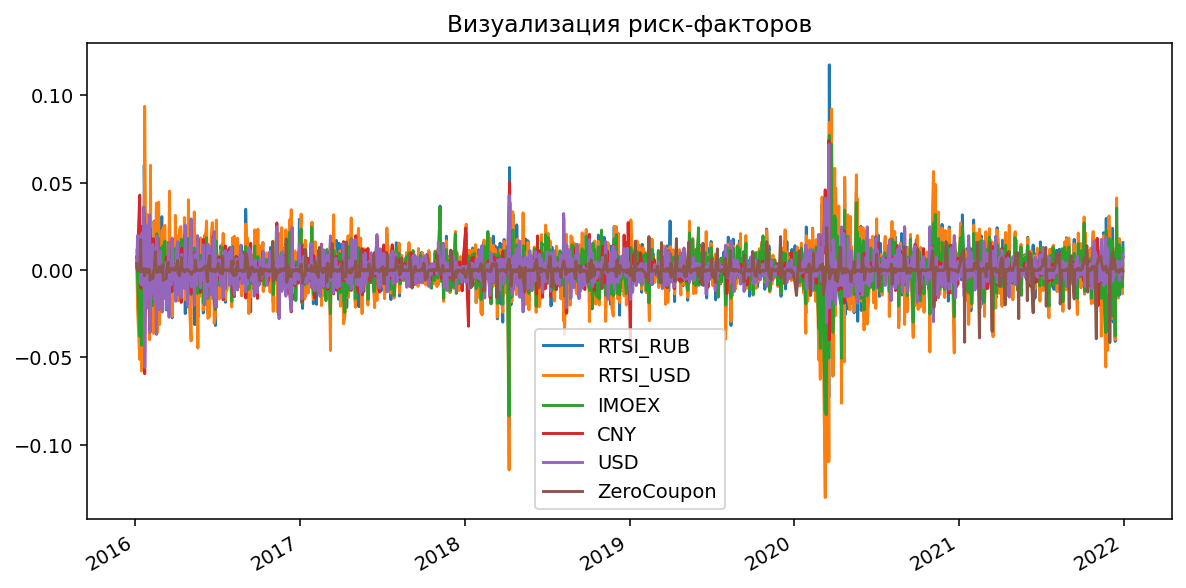

In [617]:
data.plot(title='Визуализация риск-факторов');

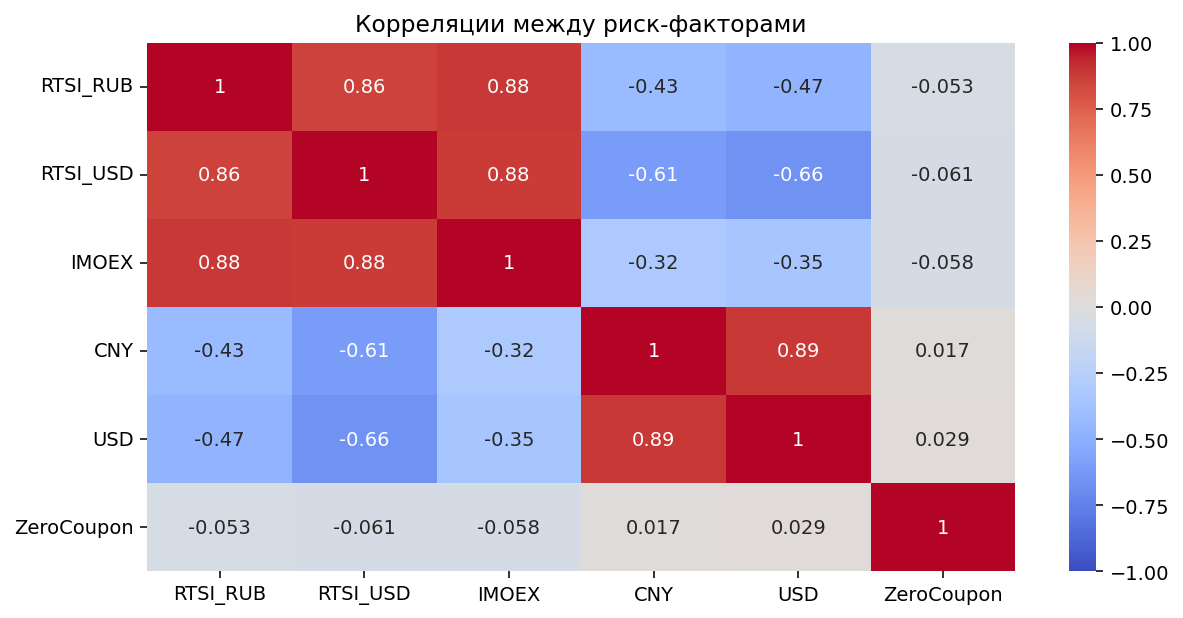

In [618]:
plt.title('Корреляции между риск-факторами')
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', vmin=-1);

array([[<AxesSubplot:title={'center':'CLOSE'}>]], dtype=object)

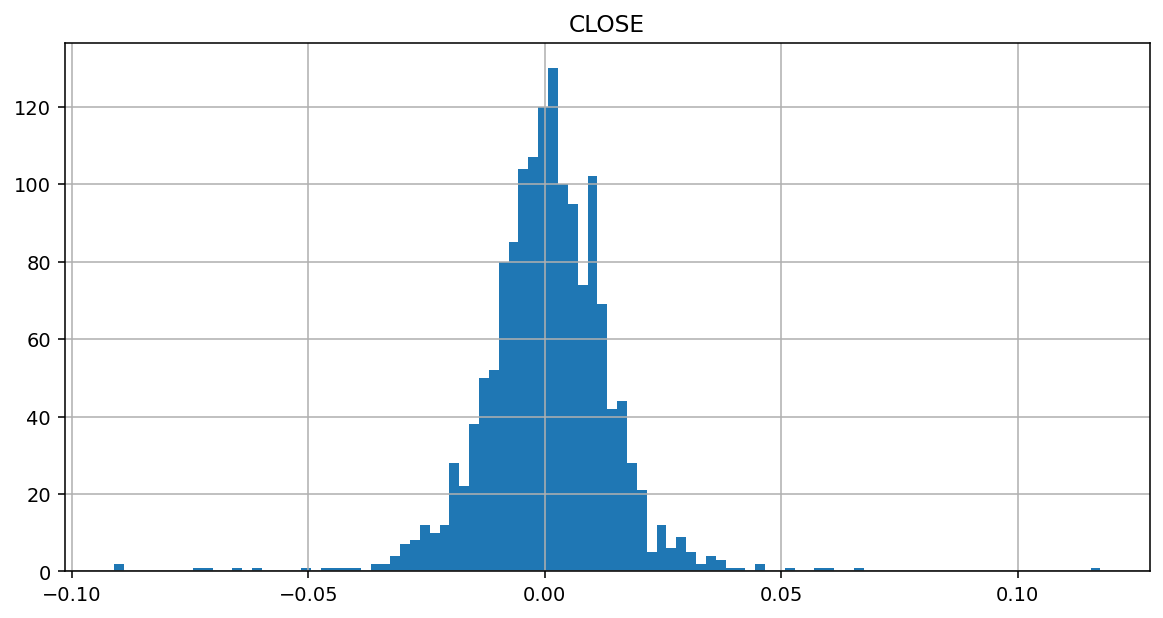

In [604]:
rtsi_DF.pct_change()[1:].CLOSE.to_frame().hist(bins=100)

RTSI_RUB


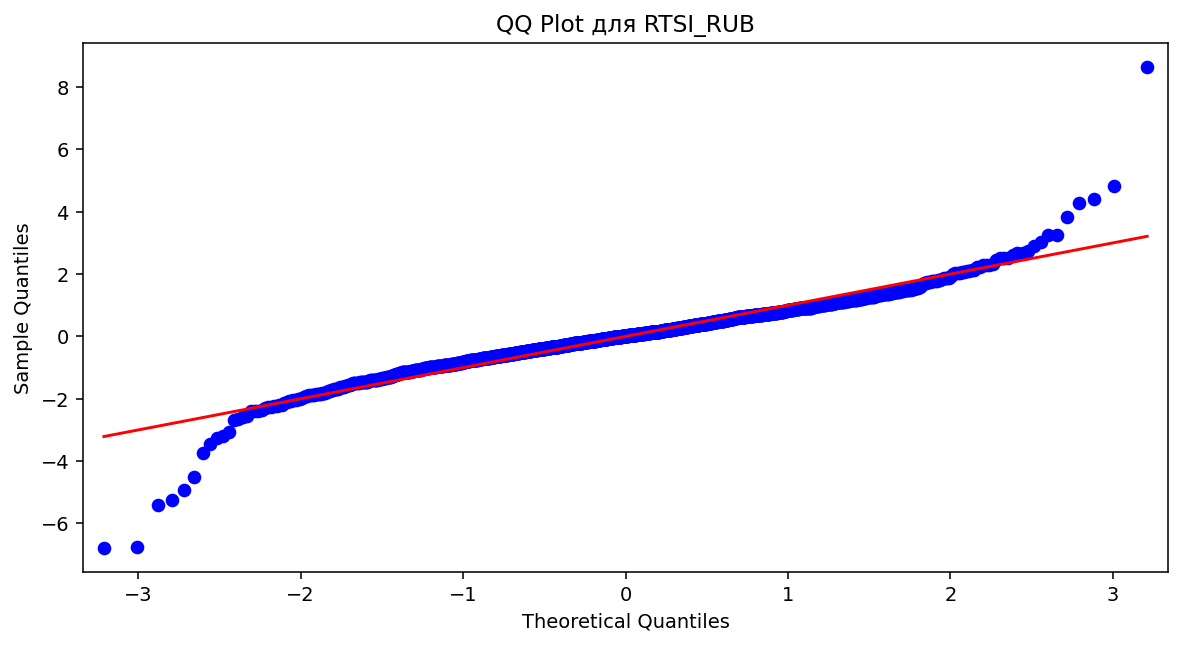

RTSI_USD


RuntimeError: The data contains non-finite values.

In [619]:
import warnings

for factor in data:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        print(factor)
        sm.qqplot(data[factor], line="s", fit=True)

    plt.title(f'QQ Plot для {factor}')
    plt.show()

In [ ]:
for factor in data:
    x = range(data.shape[0])
    trend_coefs = np.polyfit(x, data[factor], 1)
    trend = np.poly1d(trend_coefs)
    plt.plot(data[factor])
    plt.plot(data.index, trend(x))
    plt.title(f'Тренд для {factor}')
    plt.show()

In [606]:
for factor in data:
    season_data = sm.tsa.seasonal_decompose(data[factor], period=40)
    season_data.seasonal.plot()
    plt.title(f'Сезонность для {factor}')
    plt.show()

ValueError: This function does not handle missing values

In [354]:
for factor in data:
    pval = sm.tsa.stattools.adfuller(data[factor])[1]
    print(factor)
    print(f"Критерий Дики-Фуллера: p={pval:.2}")
    print('На уровне значимости 5% гипотеза о нестационарности '
          + 'отвергается' if pval <= 0.05 else 'не отвергается')
    print()

RTSI_RUB
Критерий Дики-Фуллера: p=0.0
На уровне значимости 5% гипотеза о нестационарности отвергается

RTSI_USD
Критерий Дики-Фуллера: p=0.0
На уровне значимости 5% гипотеза о нестационарности отвергается

IMOEX
Критерий Дики-Фуллера: p=3.2e-30
На уровне значимости 5% гипотеза о нестационарности отвергается



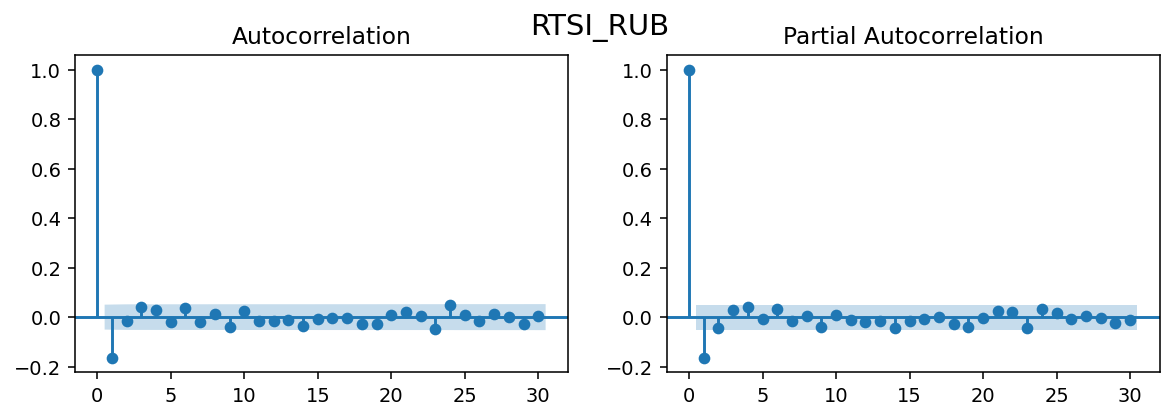

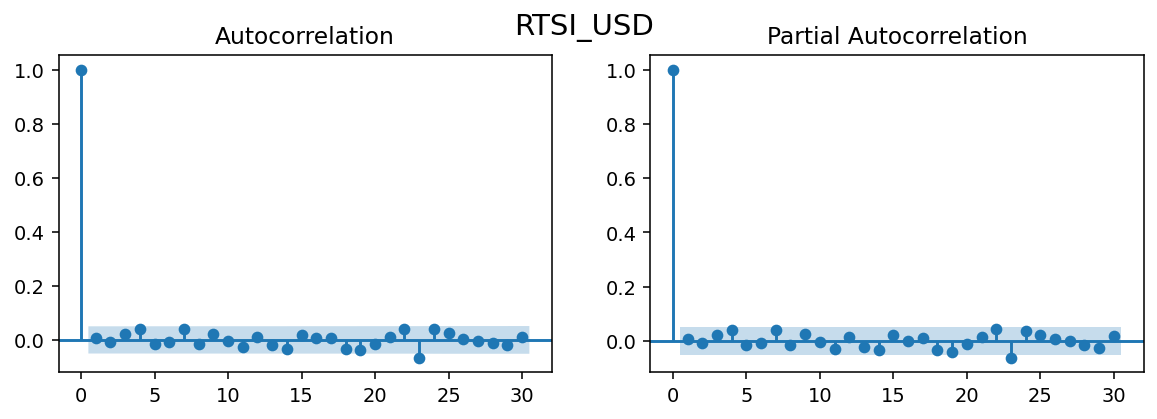

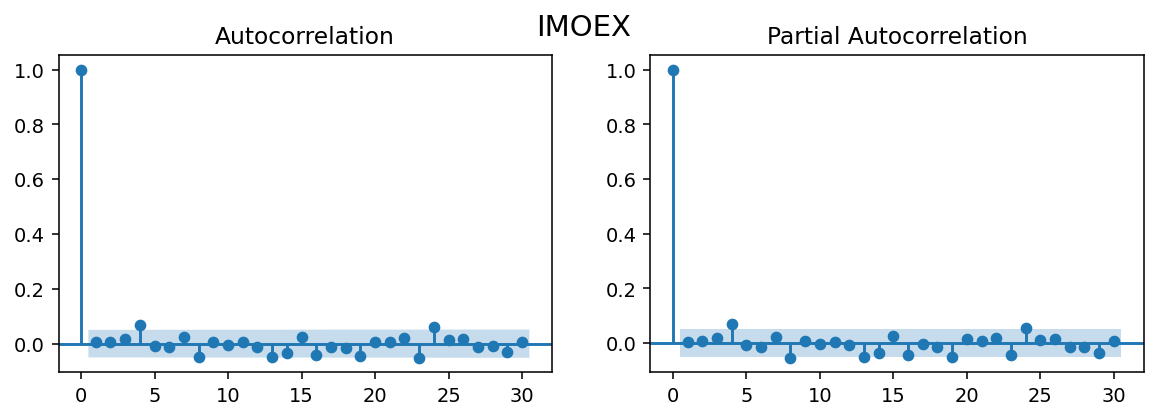

In [355]:
for factor in data:
    fig = plt.figure(figsize=(10, 3))
    layout = (1, 2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))
    sm.graphics.tsa.plot_acf(data[factor], lags=30, ax=acf_ax, alpha=0.05)
    sm.graphics.tsa.plot_pacf(data[factor], lags=30, ax=pacf_ax, alpha=0.05, method='ywm')
    fig.suptitle(factor, fontsize=15)